# 7.1 Lös advektion-diffution-ekvationen
*I det här problemet får du lösa advektion-diffution-ekvationen med finita element metoden och studera lösningens konvergens när $h \to 0$.*

> ⚠️ För att vara konsekvent med uppgiftsbeskrivningen används $\nabla$ här för att skapa kolumnvektorer. (i föregående uppgifter användes radvektorer)

## a)
Betrakta advektion-diffution-ekvationen $-\varepsilon \Delta u + \beta \cdot \nabla u = f$ med homogena Dirichlet-vilkor på området $\Omega = [-1,1] \times [-1,1]$, diffusion $\varepsilon = 1$ och advektion $\beta(x,y) = \begin{bmatrix} -y & x \end{bmatrix}^\top$. Verifiera (analytiskt) att $\beta$ är divergensfirtt, att $u(x,y) = (1-x^2)(1-y^2)$ uppfyller randvilkoren och bestäm högerledet $f$ så att $u$ löser ekvationen.

> RE: Homogena Dirichlet-villkor<br>
> $u = 0$ längs randen av området $\Omega$<br>
> $V_{h,D} = V_{h,0}$<br>
> $\Gamma_R = \emptyset\enspace$ ( $\Gamma_R$ är tom)<br>

> RE:
> $\beta(x,y) = \begin{bmatrix} \beta_1(x,y) \\ \beta_2(x,y) \end{bmatrix} = \begin{bmatrix} -y \\ x \end{bmatrix}$

### a.1) $\beta$ är divergensfritt
$= \nabla \cdot \beta(x,y)$

$= \frac{\partial \beta_1}{\partial x} + \frac{\partial \beta_2}{\partial y}$
$= \frac{\partial (-y)}{\partial x} + \frac{\partial (x)}{\partial y}$
$= 0 + 0$
$=0$

✅, $\beta$ är divergensfitt

### a.2) Randvilkor uppfylls

Randen av $\Omega$ kan delas upp i 4 delsträckor.<br>
![alt text](images/7-area.png)

$C_1: u(1, y) = (1-1^2)(1-y^2) = 0$<br>
$C_2: u(-1, y) = (1-(-1)^2)(1-y^2) =0$<br>
$C_3: u(x, 1) = (1-x^2)(1-1^2) = 0$<br>
$C_4: u(x, -1) = (1-x^2)(1-(-1)^2) = 0$<br>

✅, Randvilkoren uppfylls

### a.3) Högerledet

$f =-\varepsilon \Delta u + \beta \cdot \nabla u$

> RE: $\varepsilon = 1$

$\varepsilon\Delta u = \displaystyle\frac{\partial^2 u}{\partial x^2} + \displaystyle\frac{\partial^2 u}{\partial y^2}$<br>
$\displaystyle\frac{\partial^2 u}{\partial x^2} = \displaystyle\frac{\partial}{\partial x}\Big(-2x(1-y^2) \Big) = -2(1-y^2)$<br>
$\displaystyle\frac{\partial^2 u}{\partial y^2} = \displaystyle\frac{\partial}{\partial y}\Big(-2y(1-x^2) \Big) = -2(1-x^2)$<br>

$\varepsilon\Delta u = -2(2-x^2-y^2)$<br>
$-\varepsilon\Delta u = 2(2-x^2-y^2)$

$\def\arraystretch{1.5}\beta \cdot \nabla u = \begin{bmatrix} -y \\ x \end{bmatrix} \cdot \begin{bmatrix} \frac{\partial}{\partial x} (1-x^2)(1-y^2) \\ \frac{\partial}{\partial y} (1-x^2)(1-y^2) \end{bmatrix}$

$= \begin{bmatrix} -y \\ x \end{bmatrix} \cdot \begin{bmatrix} \frac{\partial}{\partial x} -2x(1-y^2) \\ \frac{\partial}{\partial y} -2y(1-x^2) \end{bmatrix}$

$= -(-y) 2x(1-y^2) - (x) 2y(1-x^2)$

$= 2xy-2xy(y^2) - (2xy - 2xy(x^2))$

$\beta \cdot \nabla u = 2xy(-y^2+x^2)$

Tillsammans:

$f =-\varepsilon \Delta u + \beta \cdot \nabla u$<br>
$= 2(2-x^2-y^2) + 2xy(x^2-y^2)$

✅, $f$ är löst



# b) Lös randvärdesproblemet

Finn $u \in C^2(\Omega)$<br>
$(\nabla \cdot (-\varepsilon \nabla u)) + (\beta \cdot \nabla u = f\quad \text{i} \Omega)$

## b.0) Utilities

In [1109]:
import numbers
from typing import Annotated, Any, Literal
from numpy import floating, ndarray
import numpy as np

type Matrix2x2 = ndarray[tuple[Literal[2], Literal[2]], floating]
type Matrix3x3 = ndarray[tuple[Literal[3], Literal[3]], floating]
type Vector2 = ndarray[tuple[Literal[2], Literal[1]], floating]
type Vector3 = ndarray[tuple[Literal[3], Literal[1]], floating]

def npfmt(arr: ndarray|numbers.Real) -> str:
    def fmt(a: float|list) -> str:
        if isinstance(a, list):
            if len(a) == 1:
                return fmt(a[0])
            return "[" + ", ".join(fmt(i) for i in a) + "]"
        if isinstance(a, numbers.Real):
            if a >= 0:
                return f" {a:3f}"
            else:
                return f"{a:3f}"
        raise TypeError

    if isinstance(arr, ndarray):
        return fmt(arr.tolist())
    if isinstance(arr, numbers.Real):
        return fmt(arr)
    raise TypeError

# vanliga numpy gillar inte att ta skalärprodokten av columnmatrise
def dot2(a: Vector2, b: Vector2) -> float:
    assert a.size == 2,1 == b.size
    return np.dot(a[:,0], b[:,0])

## b.1) Funktioner för Triangulisering

In [1110]:
from dataclasses import dataclass
from functools import cached_property
import matplotlib.pyplot as plt
import matplotlib.tri as tri

@dataclass
class TriangulatedGrid:
    # Vertex
    # [[x₀, y₀], [x₁, y₁], ...]
    V: ndarray[Vector2]

    # Högerorienterad lista av vertexindex
    # [[i₀, j₀, k₀], [i₁, j₁, k₁], ...]
    K: ndarray[Vector3]

    def __init__(
            self,
            nx: int, ny: int,
            xmin: int = 0, xmax: int = 1,
            ymin: int = 0, ymax: int = 1,
        ):
        V = []
        K = []

        n_vertecies_in_a_row = nx+1
        n_vertecies_in_a_column = ny+1

        for y in np.linspace(ymin, ymax, n_vertecies_in_a_column):
            for x in np.linspace(xmin, xmax, n_vertecies_in_a_row):
                V.append(np.asarray([[x], [y]]))

        # iterera genom varje hörn som har noder till höger och ovanför sig
        for y in range(ny):
            for x in range(nx):
                # Beräkna index i triangelhörnen har V
                p0 = y * n_vertecies_in_a_row + x   # Botten/Vänster hörn
                p1 = p0 + 1                         # Botten/Höger hörn
                p2 = p0 + n_vertecies_in_a_row      # Topp/Vänster corner
                p3 = p2 + 1                         # Topp/Höger corner

                # Definera de två trinaglarna motsols! (högerorienterad)
                # 3-4
                # |/|
                # 1-2
                K.append(np.asarray([[p0], [p1], [p3]]))  # Topp/Vänster triangel
                K.append(np.asarray([[p0], [p3], [p2]]))  # Botten/Höger triangel

        self.V = np.asarray(V)
        self.K = np.asarray(K)

        assert len(self.K) == 2*nx*ny, f"{len(self.K)=} ?= {2*nx*ny}"

    @cached_property
    def xs(self)-> ndarray[floating]:
        """ returnerar x koordinaterna för vetexen (i ordning)
            ex: [x₀, x₁, x₂, ...] """
        return self.V[:, 0, 0]

    @cached_property
    def ys(self) -> ndarray[floating]:
        """ returnerar y koordinaterna för vetexen (i ordning)
            ex: [y₀, y₁, y₂, ...] """
        return self.V[:, 1, 0]

    @cached_property
    def triangulation(self) -> tri.Triangulation:
        """ returnerar en matplotlib Triangulation av nätet """
        return tri.Triangulation(self.xs, self.ys, self.K[:, :, 0])

    @cached_property
    def K_coords(self) -> ndarray[ndarray[Vector2]]:
        """ returnerar en array av koordinaterna för K (istället för vertexindex) """
        return self.V[self.K][:, :, 0, :]

    @cached_property
    def K_with_coords(self) -> list[tuple[Vector3, ndarray[Vector2]]]:
        """ returnerar en iterator av formen
        (K[i], array of K[i]:s noders positioner)
        ex: ([Vec3[i₀,i₁,i₄], [Vec2[x₀, y₀], Vec2[x₁, y₁], Vec2[x₄, y₄]])...
        """
        return list(zip(self.K, self.K_coords))

def generate_mesh_2d(nx: int, ny: int) -> tuple[ndarray, ndarray]:
    trigrid = TriangulatedGrid(nx=nx, ny=ny)
    return (trigrid.V, trigrid.K)


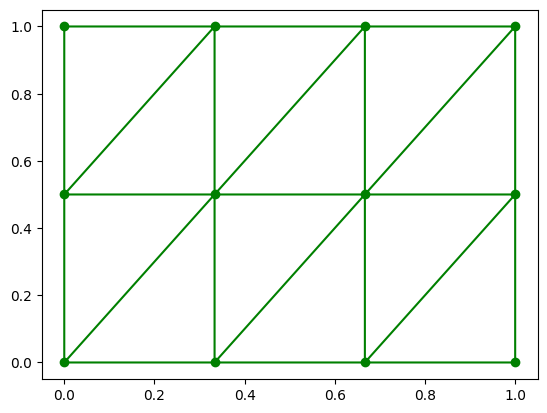

In [1111]:
def plot_mesh_2d(trigrid: TriangulatedGrid):
    plt.triplot(trigrid.triangulation, 'go-', lw=1.5)

plot_mesh_2d(TriangulatedGrid(nx=3, ny=2))

C:\Users\wilux\AppData\Local\Temp\ipykernel_9272\2667988047.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


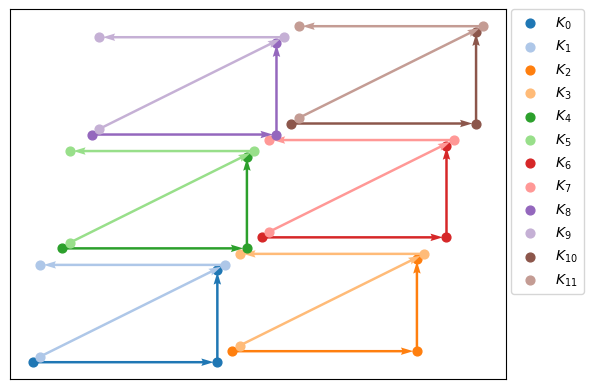

In [1112]:
# !Bonus! verifiera att k_coords är korrekt
# Plotta pilar mellan v1 -> v2 -> v3 så man se rikningen
def test_k_coords(trigrid: TriangulatedGrid):
    k_wpos = trigrid.K_with_coords
    colors = plt.get_cmap("tab20")
    fig, ax = plt.subplots()
    for i, (idxs, coords) in enumerate(k_wpos):
        #print(idxs.tolist())
        #print(coords.tolist())
        coords: ndarray[Vector2]

        # lägg till en liten offset för att se att trianglarna inte ligger ovanpå varandra
        o = i/50
        xs = coords[:, 0, 0] + o
        ys = coords[:, 1, 0] + o
        n = len(coords)
        directions = np.array([coords[(i + 1) % n, :, 0] - coords[i, :, 0] for i in range(n)])

        ax.scatter(xs, ys, color=colors(i%20), s=40, label=f"$K_{{{i}}}$")
        ax.quiver(
            xs[:-1], ys[:-1], directions[:,0][:-1], directions[:,1][:-1], color=colors(i%20),
            angles='xy', scale_units='xy', scale=1.02, width=0.005
        )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.)
    fig.show()
test_k_coords(TriangulatedGrid(nx=2, ny=3))

## b.2) Funktioner för basevaluering

För 2d är basfunktionerna definierade enligt följande:

$\begin{matrix}
\varphi_1(x,y) = a_1 + b_1x + c_1y\\
\varphi_2(x,y) = a_2 + b_2x + c_2y\\
\varphi_3(x,y) = a_3 + b_3x + c_3y\\
\end{matrix} \iff \begin{bmatrix}
\varphi_1(x,y) \\
\varphi_2(x,y) \\
\varphi_3(x,y) \\
\end{bmatrix} = \begin{bmatrix}
a_1 & b_1 & c_1 \\
a_2 & b_2 & c_2 \\
a_3 & b_3 & c_3 \\
\end{bmatrix}\begin{bmatrix}
1\\x\\y\\
\end{bmatrix}$

> ⚠️ åtminstånde innanför triangeln, utanför simplexen är alla $\varphi$ = 0

Om vi låter triangels hörn vara $\left[\begin{smallmatrix}x_1\\y_1\end{smallmatrix}\right], \left[\begin{smallmatrix}x_2\\y_2\end{smallmatrix}\right], \left[\begin{smallmatrix}x_3\\y_3\end{smallmatrix}\right]$ kan vi sätta upp ett ekvationssystem

$\varphi_1(x_1,y_1)=1$, $\varphi_1(x_2,y_2)=0$, $\varphi_1(x_3,y_3)=0$<br>
$\varphi_2(x_1,y_1)=0$, $\varphi_2(x_2,y_2)=1$, $\varphi_2(x_3,y_3)=0$<br>
$\varphi_3(x_1,y_1)=0$, $\varphi_3(x_2,y_2)=0$, $\varphi_3(x_3,y_3)=1$<br>

Skriv upp ekvationen som en matris:

$\begin{bmatrix}
a_1 & b_1 & c_1 \\
a_2 & b_2 & c_2 \\
a_3 & b_3 & c_3 \\
\end{bmatrix} \begin{bmatrix}
  1 &   1 &   1 \\
x_1 & x_2 & x_3 \\
y_1 & y_2 & y_3 \\
\end{bmatrix} = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1\\
\end{bmatrix} = AB = I$

$\iff A = B^{-1}$

För referensbasfunktionerna $\varphi$ blir $A$ mycket snäll att lösa: i de flesta andra situationer är det komplicerat.

$\begin{bmatrix}
1 & -1 & -1\\
0 & 1 & 0\\
0 & 0 & 1\\
\end{bmatrix}$

Altså:

$\hat{\varphi}_1(\hat{x}, \hat{y}) = 1-\hat{x}-\hat{y}$<br>
$\hat{\varphi}_2(\hat{x}, \hat{y}) = \hat{x}$<br>
$\hat{\varphi}_3(\hat{x}, \hat{y}) = \hat{y}$<br>

Ideen med använda referensbasfunktionerna är att denna formel är mycket enkel beräkna. Om vi kan transformera en godtycklig triangel till refernsbasen, lösa problemet där och sen transformera tillbaka blir det lättare att lösa problem.


> RE: vi visade i uppgift 8 att:
>
> $\nabla\varphi(x) = \left(F_K'\right)^{-\top}\cdot\hat{\varphi}'\left(F_K^{-1}(x)\right)$
>
> $\nabla\varphi(x) = (F_K')^{-\top}\cdot\nabla_{\hat{x}}\hat{\varphi}(F_K^{-1}(x))$
>
> $\nabla\varphi(x) = (\nabla_{\hat{x}}F_K)^{-\top}\cdot\nabla_{\hat{x}}\hat{\varphi}(F_K^{-1}(x))$
>
> $\nabla\varphi = (F_K')^{-\top} \cdot \nabla_{\hat{x}}\hat{\varphi} \circ F_K^{-1}$

In [1113]:
def referensbas_phi(i: int, pos: Vector2) -> float:
    (x,), (y,) = pos
    match i:
        case 0: return 1-x-y
        case 1: return x
        case 2: return y
        case _: raise ValueError("Not a valid base index")

def referensbas_nabla_phi(i: int, pos: Vector2) -> Vector2:
    # I 2d trianglar spelar det ingen roll vad argumentet till ∇_x̂ φ är
    (x,), (y,) = pos
    match i:
        case 0: return np.asarray([[-1], [-1]])
        case 1: return np.asarray([[ 1], [ 0]])
        case 2: return np.asarray([[ 0], [ 1]])
        case _: raise ValueError("Not a valid base index")

def evaluate_basis_2d(
        i: int,
        x: Vector2,
        X: ndarray[Vector2]
    ) -> tuple[Annotated[float, "φ"], Annotated[Vector2, "∇φ"]]:
    """
    i: val of referensbas [1, 3]
    x: vilken position att evaluera på
    X: vilka positioner hörnen i den lokala triangeln har
    """
    #============ SETUP =============#
    # Gör triangelhörnern till till kolumnvektorer
    v0: Vector2 = X[0]
    v1: Vector2 = X[1]
    v2: Vector2 = X[2]

    # RE> ekvation 5.82
    F_k_jacobi: Matrix2x2 = np.hstack([v1-v0, v2-v0])
    F_k_jacobi_inv = np.linalg.inv(F_k_jacobi)

    # RE> ekvation 5.81
    # Fₖ(x̂) = x
    # Fₖ⁻¹(x) = x̂
    # Fₖ(x̂) = Ax̂+b
    # => Fₖ⁻¹(x) = A⁻¹(x-b)
    #============ BÖRJA LÖSA PROBLMET =============#
    local_x: Vector2 = F_k_jacobi_inv @ (x - v0)

    #print(f"local_x={npfmt(local_x)} x={npfmt(x)}")

    # RE> Ekvation 5.88
    hat_phi = referensbas_phi(i, local_x)

    # RE> sats 5.3 / Uppgift 8
    nabla_hat_phi = F_k_jacobi_inv.T @ (
        referensbas_nabla_phi(i, local_x)
    )

    #assert is_within_triangle(x, X)
    #assert is_within_triangle(local_x, np.asarray([[[0],[0]], [[1],[0]], [[0],[2]]]))
    #assert phi <= 1
    #
    #assert (
    #       np.allclose(local_x, np.asanyarray([[0], [0]]))
    #    or np.allclose(local_x, np.asanyarray([[1], [0]]))
    #    or np.allclose(local_x, np.asanyarray([[0], [1]]))
    #), f"Got local_x={npfmt(local_x)}"
    #
    #assert nabla_phi

    return hat_phi, nabla_hat_phi

In [1114]:
def test_evaluate_basis_2d():
    def test(i, x, X):
        phi, nabla_phi = evaluate_basis_2d(i=i, x=x, X=X)
        print(f"{i=} -> x={npfmt(x)} φ={float(phi)}, ∇φ={npfmt(nabla_phi)}")

    p: Vector2 = np.asarray([[0.5], [0.5]])
    X: ndarray[Vector2] = np.asarray([[[0],[0]], [[1],[0]], [[0],[1]]])

    print("Verifiera (0.5, 0.5)")
    test(i=0, x=p, X=X)
    test(i=1, x=p, X=X)
    test(i=2, x=p, X=X)

    for im1, corner in enumerate(X):
        i = im1+1
        print(f"Verifiera hörn {i}")
        test(i=0, x=corner, X=X)
        test(i=1, x=corner, X=X)
        test(i=2, x=corner, X=X)

test_evaluate_basis_2d()

Verifiera (0.5, 0.5)
i=0 -> x=[ 0.500000,  0.500000] φ=0.0, ∇φ=[-1.000000, -1.000000]
i=1 -> x=[ 0.500000,  0.500000] φ=0.5, ∇φ=[ 1.000000,  0.000000]
i=2 -> x=[ 0.500000,  0.500000] φ=0.5, ∇φ=[ 0.000000,  1.000000]
Verifiera hörn 1
i=0 -> x=[ 0.000000,  0.000000] φ=1.0, ∇φ=[-1.000000, -1.000000]
i=1 -> x=[ 0.000000,  0.000000] φ=0.0, ∇φ=[ 1.000000,  0.000000]
i=2 -> x=[ 0.000000,  0.000000] φ=0.0, ∇φ=[ 0.000000,  1.000000]
Verifiera hörn 2
i=0 -> x=[ 1.000000,  0.000000] φ=0.0, ∇φ=[-1.000000, -1.000000]
i=1 -> x=[ 1.000000,  0.000000] φ=1.0, ∇φ=[ 1.000000,  0.000000]
i=2 -> x=[ 1.000000,  0.000000] φ=0.0, ∇φ=[ 0.000000,  1.000000]
Verifiera hörn 3
i=0 -> x=[ 0.000000,  1.000000] φ=0.0, ∇φ=[-1.000000, -1.000000]
i=1 -> x=[ 0.000000,  1.000000] φ=0.0, ∇φ=[ 1.000000,  0.000000]
i=2 -> x=[ 0.000000,  1.000000] φ=1.0, ∇φ=[ 0.000000,  1.000000]


## b.3) Funktioner för att visualisera nätet

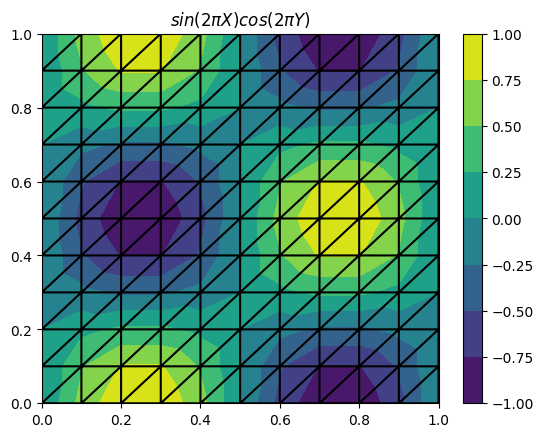

In [1115]:
def show_trigrid_evaluated(trigrid: TriangulatedGrid, values, title: str = "<No Title>"):
    triag = trigrid.triangulation
    plt.title(title)
    plt.tricontourf(triag, values, cmap="viridis")
    plt.triplot(triag, "k-")
    plt.colorbar()
    plt.show()

def show_trigrid_evaluated_example(trigrid: TriangulatedGrid):
    # Godtycklig funktion
    values = np.sin(2*np.pi*trigrid.xs) * np.cos(2*np.pi*trigrid.ys)
    show_trigrid_evaluated(trigrid, values, title="$sin(2πX)cos(2πY)$")

show_trigrid_evaluated_example(TriangulatedGrid(10, 10))

C:\Users\wilux\AppData\Local\Temp\ipykernel_9272\2667988047.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


k_0: ∇φ_2 = [ 0.000000,  2.000000], φ=1.0
k_1: ∇φ_1 = [ 2.000000,  0.000000], φ=1.0
k_3: ∇φ_2 = [-2.000000,  2.000000], φ=1.0
k_4: ∇φ_1 = [ 2.000000, -2.000000], φ=1.0
k_6: ∇φ_0 = [-2.000000,  0.000000], φ=1.0
k_7: ∇φ_0 = [ 0.000000, -2.000000], φ=1.0


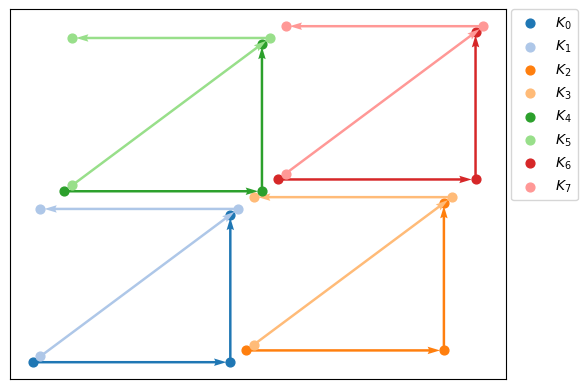

In [1116]:
# !BONUS! verifiera basevaluering på en annan triangel (Exempel 5.5)
def test_5_5():
    trigrid = TriangulatedGrid(2,2)
    test_k_coords(trigrid)
    for k_num, (v_idxs, k_pos) in enumerate(trigrid.K_with_coords):
        for (local_i, glob_i), corner_pos in zip(enumerate(v_idxs), k_pos):
            if glob_i != 4:
                continue

            # nod position
            x: Vector2 = corner_pos

            v: float; nabla_v: Vector2; x: Vector2
            v, nabla_v = evaluate_basis_2d(i=local_i, x=x, X=k_pos)

            print(f"k_{k_num}: ∇φ_{local_i} = {npfmt(nabla_v)}, φ={v}")

test_5_5()

## b.4) Härledning av Styvhetsmatris för advektions-diffusion

> RE: Uppgiftsdefinition
>
> Bok: $\quad\nabla \cdot -\kappa \nabla u + \beta \cdot \nabla u = f$
>
> Uppgift: $\quad-\varepsilon \Delta u + \beta \cdot \nabla u = f$

> RE: Laplacianen (~ekvation 6.3)
>
> $\Delta u = \nabla \cdot \nabla u$

> RE: Styvhetsmatris i 1d, (stationär värmeledning) (6.123)
>
> $\displaystyle\sum_{j=1}^N U_j
\underbrace{\int_\Omega \kappa \nabla\varphi_j \cdot \varphi_i dx + {\int_\Gamma}_R \gamma \varphi_j \varphi_i ds}_{\large a_{ij}} = \underbrace{\int_\Omega f\varphi_i dx + {\int_\Gamma}_R (g_R + \gamma u_R) \varphi_i ds}_{\large b_{i}}$

> RE: Styvhetsmatris i 1d, (stationär värmeledning) där $\Gamma_R = \empty$
>
> $\displaystyle\sum_{j=1}^N U_j
\underbrace{\int_\Omega \kappa \nabla\varphi_j \cdot \varphi_i dx}_{\large a_{ij}} = \underbrace{\int_\Omega f\varphi_i dx}_{\large b_{i}}$
>
> Altså: $AU = b$
>
>> RE: stationär värmeledning
>>
>> $\nabla \cdot (-\kappa \nabla u) = f = -\kappa \Delta u$

Nu vill vi sätta upp styvhetsmatrisen/lastvektorn för advektions-diffusions-ekvationen med  $\Gamma_R = \empty$

$f = f_1 + f_2 = -\varepsilon \Delta u + \beta \cdot \nabla u$
<br>$f_1 = -\varepsilon \Delta u = \nabla \cdot (-\varepsilon \nabla u)$
<br>$f_2 = \beta \cdot \nabla u$

Vi väjer $\varphi_i$ som testfunktion

$\displaystyle\int_\Omega (\nabla \cdot (-\varepsilon \nabla u) + \beta \cdot \nabla u) \varphi_i dx = \displaystyle\int_\Omega f\varphi_i dx$

$\displaystyle\int_\Omega \left(\nabla \cdot \left(-\varepsilon \nabla u \right)\right) \varphi_i dx + \displaystyle\int_\Omega \left(\beta \cdot \nabla u \right) \varphi_i dx = \displaystyle\int_\Omega f_1\varphi_i dx + \displaystyle\int_\Omega f_2\varphi_i dx$

Vi skriver om vänstra integralen och $f_1$ mha divergenssatsen (samma som värmeledning)

> RE:
>
> $\int_\Omega \nabla \cdot (-\kappa \nabla u) v dx = \int_\Omega f v dx$
>
> $\iff$
>
> $\displaystyle\int_\Omega \kappa \nabla u \cdot \nabla v dx + {\int_\Gamma}_R \gamma uv ds = \int_\Omega fv dx + {\int_\Gamma}_R \gamma (g_R + \gamma u_R) v ds $

Med $\Gamma_R = \empty$ får vi:

$\displaystyle\int_\Omega \varepsilon \nabla u \cdot \nabla \varphi_i dx + \displaystyle\int_\Omega \left(\beta \cdot \nabla u \right) \varphi_i dx = \displaystyle\int_\Omega f_1\varphi_i dx + \displaystyle\int_\Omega f_2\varphi_i dx$

Vi sätter ihop $f_1$ och $f_2$ igen då dom lämnades opåverkade av divergenssatstransformationen.

$\displaystyle\int_\Omega \varepsilon \nabla u \cdot \nabla \varphi_i dx + \displaystyle\int_\Omega \left(\beta \cdot \nabla u \right) \varphi_i dx = \displaystyle\int_\Omega f\varphi_i dx$


Vi skriver nu om med den svaga formen

> RE: (6.128)
>
> $u_h = \displaystyle\sum_{j=1}^N U_j\varphi_j$

$\displaystyle\int_\Omega \varepsilon \nabla \left[\displaystyle\sum_{j=1}^N U_j\varphi_j\right] \cdot \nabla \varphi_i dx + \displaystyle\int_\Omega \left(\beta \cdot \nabla \left[\displaystyle\sum_{j=1}^N U_j\varphi_j\right] \right) \varphi_i dx = \displaystyle\int_\Omega f\varphi_i dx$


Vi tar ut det som är obeoende av $x$ från integralerna

$\displaystyle\sum_{j=1}^N U_j \left[ \displaystyle\int_\Omega \varepsilon \nabla \varphi_j \cdot \nabla \varphi_i dx + \displaystyle\int_\Omega \left(\beta \cdot \nabla \varphi_j \right) \varphi_i dx \right] = \displaystyle\int_\Omega f\varphi_i dx$

$\displaystyle\sum_{j=1}^N U_j \displaystyle\int_\Omega \left( \varepsilon \nabla \varphi_j \cdot \nabla \varphi_i + \left(\beta \cdot \nabla \varphi_j \right) \varphi_i \right) dx = \displaystyle\int_\Omega f\varphi_i dx$

Till sist skriver vi om det som en matris multiplikation

$\displaystyle\sum_{j=1}^N U_j \underbrace{\displaystyle\int_\Omega \left(\varepsilon \nabla \varphi_j \cdot \nabla \varphi_i + \beta \cdot \nabla \varphi_j \varphi_i \right) dx}_{A_{ij}} = \underbrace{\displaystyle\int_\Omega f\varphi_i dx}_{B_i}$

$AU = B$

> ⚠️ Notera att $B$ är en kolumnvektor trots att jag här använder stor bokstav. Detta för att inte förvirra denna med $a,b,a_K,b_K$ som används i nästa stycke

> RE: Kovertering mellan matrismultiplikation och summor
>
> $X \in \mathbb{R}^{m \times n}$, $Y \in \mathbb{R}^{n \times w}$
>
> $(X \cdot Y)_i = \displaystyle\sum_{k\in \{1 \dots n\}} X_{ik} \cdot Y_{k}$

## b.5) Assemblering

Vi börjar med att införa följande betckning för att slippa skriva ut hela vår integral.

$A_{ij} = \underbrace{\int_{\Omega} (\varepsilon \nabla \varphi_j \cdot \nabla \varphi_i + \left(\beta \cdot \nabla \varphi_j \right) \varphi_i) dx}_{a(\varphi_i, \varphi_j)}$

$B_{i} = \underbrace{\int_{\Omega} f\varphi_i dx}_{b(\varphi_i)}$

En naiv beräking av styhetsmatrisen och lastvektorn kan göras enligt följande:

$\text{for } i = 1,2, \dots , \#V$<br>
$\quad\text{for } i = 1,2, \dots , \#V$<br>
$\quad\quad A_{ij} = a(\varphi_i, \varphi_j)$

$\text{for } i = 1,2, \dots , \#V$<br>
$\quad b_{ij} = b(\varphi_i)$

Men vi kan vara fiffigare då $\varphi_i/\varphi_j$ är noll nästan överallt

Istället för att iterara genom varje $a_{ij}$ och sen för varje triangel i nätet aproximera integralen kan vi spara mycket arbete genom itera genom varje triangel och endast addera effekterna på de $a_{ij}$ som påverkas av triangeln.

> RE: Uppdelining (5.203)
>
>$\displaystyle\int_{\cal K} f(x)dx = \displaystyle\sum_{K \in {\cal K}} {\int_K} f(x)dx$

$A_{ij} = \displaystyle\sum_{K \in {\cal K}} \underbrace{\int_{\Omega_K} (\varepsilon \nabla \varphi_j \cdot \nabla \varphi_i + \left(\beta \cdot \nabla \varphi_j \right) \varphi_i) dx}_{a_K(\varphi_i, \varphi_j)}$

$B_{i} = \displaystyle\sum_{K \in {\cal K}} \underbrace{\int_{\Omega_K} f\varphi_i dx}_{b_K(\varphi_i)}$

Där $\Omega_K$ är den högerorienterad ytan som bildas av de tre triangelpunkter i respektive triangel av ${\cal K}$ och $a_K$/$b_K$ är triangeln $K$:s tillskott.

> RE: $({\cal V}, {\cal K})$ är trianguliseringen av $\Omega$

Med denna omskrivning har vi fortfarande inte tjänat något, men nästa optimisering att vi kan ignorera nästan alla delar trianglar vid beräkning av $a_{ij}$/$b_{i}$.

Detta är för att alla trianglar förutom dom som innehåller $V_i$ kommer få $\varphi_i$ lika med 0.

Formellt sätt har vi följande: (6.242)

$A_{ij} = \sum_{K \in {\cal K}} a_K(\varphi_i, \varphi_j) = \sum_{K \in {\cal K}_{ij}} a_K(\varphi_i, \varphi_j)$

Där ${\cal K}_{ij}$ är det subset:et av ${\cal K}$ där $\varphi_i, \varphi_j \ne 0$

### Hur aproximerar vi $a_k(\varphi_i, \varphi_j)$ och $b_k(\varphi_i)$?

> RE: (6.254)
>
> $A_{IJ} = \displaystyle\sum_{K \in {\cal K}_{IJ}} A^K_{ij}$
>
> Där $A^K_{ij}$ är elementstyvhetsmatrisen för elementet $K$ där lilla $i,j$ är index bland dess lokala basfunktioner, (dom 3 basfunktionerna som är med i triangeln K)

> RE: (6.255)
>
> $A^K_{ij} = a_K(\varphi_j^K, \varphi_i^K)$
>
> $\varphi^K$ är .... TODO

> RE: Vi visade i **b.2** hur vi kan transformera en godtycklig triangel till referenbasen
>
> $\varphi^K(x) = \hat{\varphi}(F_K^{-1}(x))$
>
> $\nabla\varphi^K(x) = (F_K')^{-\top}\cdot\nabla_{\hat{x}}\hat{\varphi}(F_K^{-1}(x))$

För advektion-diffusion får vi:

$A^K_{ij} = +\displaystyle\int_{\Omega_K} (\varepsilon \nabla \varphi_j^K \cdot \nabla \varphi_i^K + \left(\beta \cdot \nabla \varphi_j^K \right) \varphi_i^K) dx$



> RE: Aproximation (5.203)
>
>$\displaystyle\int_K f(x)dx ≈ \displaystyle\sum_{k=1}^{N_q} w_k f(x_k)$

In [1117]:
def triangle_area(points: ndarray[Vector2]) -> float:
    ((x1,), (y1,)), ((x2,), (y2,)), ((x3,), (y3,)) = points
    area = 0.5 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    return area

@dataclass
class Quadrature2D:
    Xs: ndarray[Vector2]
    Ws: ndarray[float]
    @cached_property
    def pairs(self) -> list[tuple[Vector2, float]]:
        """ returnerar en iterator av formen (kvadraturpunkt, kvadraturvikt)"""
        return list(zip(self.Xs, self.Ws))
def generate_quadrature_2d(X: ndarray[Vector2]):
    area = triangle_area(X)
    x0: Vector2 = X[0]
    x1: Vector2 = X[1]
    x2: Vector2 = X[2]
    return Quadrature2D(
        Xs = np.asarray([(x0+x1)/2, (x0+x2)/2, (x1+x2)/2]),
        Ws = np.asarray([area/3, area/3, area/3])
    )

def test_generate_quadrature_2d():
    unit_X: ndarray[Vector2] = np.asarray([[[0],[0]], [[1],[0]], [[0],[1]]])
    q = generate_quadrature_2d(unit_X)
    print(f"Xs={npfmt(q.Xs)}, Ws={npfmt(q.Ws)}")
test_generate_quadrature_2d()

Xs=[[ 0.500000,  0.000000], [ 0.000000,  0.500000], [ 0.500000,  0.500000]], Ws=[ 0.166667,  0.166667,  0.166667]


In [1118]:
from typing import Callable

@dataclass
class AkIntegrandArgs:
    u: float
    v: float
    nabla_u: Vector2
    nabla_v: Vector2
    x: Vector2
    dx: float
def compute_element_matrix_2d(
        X: ndarray[Vector2],
        I: Callable[[AkIntegrandArgs], float]
    ) -> Matrix3x3:
    """
    K: lista av hörnkoordnater för triangel [[x₀; y₀], [x₁; y₁], ...)
    I: Integrand
    """
    # ========= SETUP ==========
    n_points = len(X) # borde vara #dims + 1
    Ak: Matrix3x3 = np.zeros((n_points, n_points))

    v: float; u: float; nabla_v: Vector2; nabla_u: Vector2; x: Vector2
    # ========= Beräkna m.h.a hörnkvadratur ==========
    for x, dx in generate_quadrature_2d(X).pairs:
        for i in range(n_points):
            v, nabla_v = evaluate_basis_2d(i=i, x=x, X=X)
            for j in range(n_points):
                u, nabla_u = evaluate_basis_2d(i=j, x=x, X=X)
                Ak[i, j] += I(AkIntegrandArgs(u=u, v=v, nabla_u=nabla_u, nabla_v=nabla_v, x=x, dx=dx))

    #print(f"K={npfmt(K)} -> A={npfmt(A)}")

    return Ak

@dataclass
class BkIntegrandArgs:
    v: float
    nabla_v: Vector2
    x: Vector2
    dx: float
def compute_element_vector_2d(
        X: ndarray[Vector2],
        I: Callable[[BkIntegrandArgs], float]
    ) -> Vector3:
    """
    K: lista av hörnkoordnater för triangel [[x₀; y₀], [x₁; y₁], ...)
    I: Integrand
    """
    # ========= SETUP ==========
    n_points = len(X) # borde vara #dims + 1
    Bk: Vector3 = np.zeros((n_points, 1))

    v: float; nabla_v: Vector2; x: Vector2
    # ========= Beräkna m.h.a hörnkvadratur ==========
    for x, dx in generate_quadrature_2d(X).pairs:
        for i in range(n_points):
            v, nabla_v = evaluate_basis_2d(i=i, x=x, X=X)
            Bk[i, 0] += I(BkIntegrandArgs(v=v, nabla_v=nabla_v, x=x, dx=dx))

    return Bk

In [1119]:
def poisson_lhs(i: AkIntegrandArgs):
    epsilon = 1.0
    return dot2(epsilon * i.nabla_u, i.nabla_v) * i.dx
def poisson_rhs(i: BkIntegrandArgs):
    (x,), (y,) = i.x
    a = 0.25
    f = np.exp(-((x-0.5)**2+(y-0.5)**2) / (2*a**2))
    #print(f"ix={npfmt(i.x)} iv={i.v} dx={npfmt(i.dx)} f={f}, ret={i.v*f*i.dx}")
    return f * i.v * i.dx

def test_compute_element_2d():

    ones: Vector2 = np.asarray([[1], [1]])
    lhs = poisson_lhs(AkIntegrandArgs(u=1, v=1, nabla_u=ones, nabla_v=ones, x=ones, dx=1))
    rhs = poisson_rhs(BkIntegrandArgs(v=1, nabla_v=ones, x=ones, dx=1))

    unit_X: ndarray[Vector2] = np.asarray([[[0],[0]], [[1],[0]], [[0],[1]]])
    ak = compute_element_matrix_2d(X=unit_X, I=poisson_lhs)
    bk = compute_element_vector_2d(X=unit_X, I=poisson_rhs)

    print(f"lhs={npfmt(lhs)}")
    print(f"rhs={npfmt(rhs)}")
    print(f"ak={npfmt(ak)}")
    print(f"bk={npfmt(bk)}")
test_compute_element_2d()

lhs= 2.000000
rhs= 0.018316
ak=[[ 1.000000, -0.500000, -0.500000], [-0.500000,  0.500000,  0.000000], [-0.500000,  0.000000,  0.500000]]
bk=[ 0.022556,  0.094611,  0.094611]


In [1120]:
from scipy.sparse import csr_matrix

@dataclass
class DirilechtArgs:
    trigrid: TriangulatedGrid
    mut_A: ndarray
    mut_B: ndarray

@dataclass
class StiffnessMatrixSolve2d:
    A: csr_matrix
    B: ndarray

    def __init__(
            self,
            trigrid: TriangulatedGrid,
            lhs: Callable[[AkIntegrandArgs], float],
            rhs: Callable[[BkIntegrandArgs], float],
            dirilecht: None|Callable[[DirilechtArgs], None] = None,
        ):
        n_points = len(trigrid.V)
        A = csr_matrix((n_points, n_points))
        B: ndarray = np.zeros((n_points,1))

        # v_idxs = [vilket index triangelhörnet har i trigrid V]
        # k_poss = [x;y positionerna för triangelhörnet]
        for v_idxs, k_poss in trigrid.K_with_coords:
            bk: Vector3 = compute_element_vector_2d(X=k_poss, I=rhs)
            for local_i, glob_i in enumerate(v_idxs):
                #print(f"gbl:{glob_i} -> {npfmt(bk)}")
                B[glob_i, 0] += bk[local_i, 0]

        for v_idxs, k_poss in trigrid.K_with_coords:
            ak: Matrix3x3 = compute_element_matrix_2d(X=k_poss, I=lhs)
            for local_i, glob_i in enumerate(v_idxs):
                for local_j, glob_j in enumerate(v_idxs):
                    #gfi=7
                    #gfj=6
                    #if glob_i == gfi and glob_j == gfj:
                    #    print(f"K_{ki} modifies A({gfi},{gfj})")

                    A[glob_i, glob_j] += ak[local_i, local_j]

        if dirilecht is not None:
            dirilecht(DirilechtArgs(trigrid, mut_A=A, mut_B=B))

        # verifiera att positiv definit
        #np.linalg.cholesky(A.toarray())

        self.A = A
        self.B = B

In [1121]:
def test_assemble():
    trigrid = TriangulatedGrid(1,1)
    s = StiffnessMatrixSolve2d(trigrid, lhs=poisson_lhs, rhs=poisson_rhs)
    print(f"A={s.A.toarray()}")
    print(f"B={npfmt(s.B)}")
test_assemble()

A=[[ 1.  -0.5 -0.5  0. ]
 [-0.5  1.   0.  -0.5]
 [-0.5  0.   1.  -0.5]
 [ 0.  -0.5 -0.5  1. ]]
B=[ 0.189223,  0.022556,  0.022556,  0.189223]


nonco pidx=4
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]


C:\Users\wilux\AppData\Local\Temp\ipykernel_9272\2667988047.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\wilux\AppData\Local\Temp\ipykernel_9272\3134101190.py:20: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  U: ndarray = scipy.sparse.linalg.spsolve(A, B)


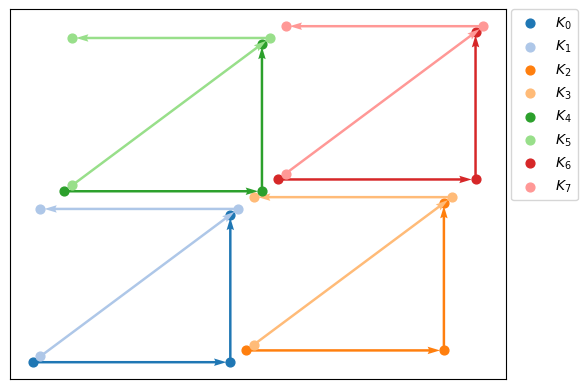

In [1122]:
import scipy.sparse.linalg

def test_dirichlet_bc_2d():
    trigrid = TriangulatedGrid(2,2)
    test_k_coords(trigrid)
    A = np.ones((9,9))
    B = np.ones((9,1))

    for pidx, ((x,), (y,)) in enumerate(trigrid.V):
        # nollställ alla A/B som ligger på randen av Omega
        if x == 0 or x == 1 or y == 0 or y == 1:
            A[pidx, :] = 0
            B[pidx] = 0
        else:
            print(f"nonco {pidx=}")

        # diagonalen ska vara 1
        A[pidx, pidx] = 1

    U: ndarray = scipy.sparse.linalg.spsolve(A, B)
    print(f"{A}")
    print(f"{B}")
    print(f"{U}")
test_dirichlet_bc_2d()


> RE:
>
> $A_{ij} = \displaystyle\sum_{K \in {\cal K}} \underbrace{\int_{\Omega_K} (\varepsilon \nabla \varphi_j \cdot \nabla \varphi_i + \left(\beta \cdot \nabla \varphi_j \right) \varphi_i) dx}_{a_K(\varphi_i, \varphi_j)}$
>
> $B_{i} = \displaystyle\sum_{K \in {\cal K}} \underbrace{\int_{\Omega_K} f\varphi_i dx}_{b_K(\varphi_i)}$
>
> $f = 2(2-x^2-y^2) + 2xy(x^2-y^2)$
>
> $f = (\nabla \cdot -\varepsilon \nabla u) + \beta \cdot \nabla u$
>
> $AU = B$

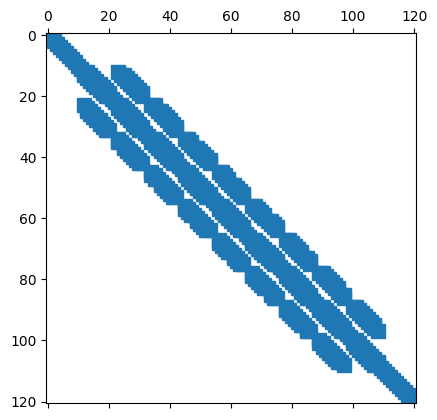

solve.A.shape=(121, 121) solve.B.shape=(121, 1) U.shape=(121,) trigrid.V.shape=(121, 2, 1)


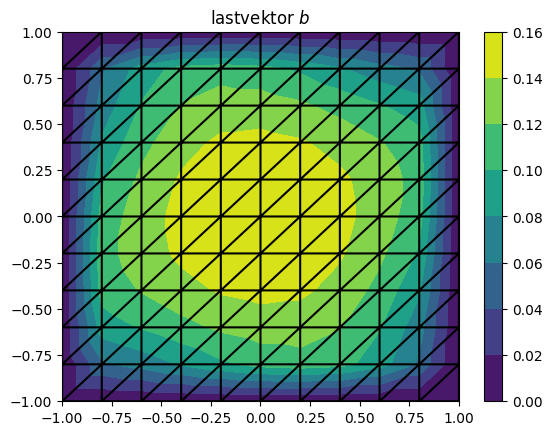

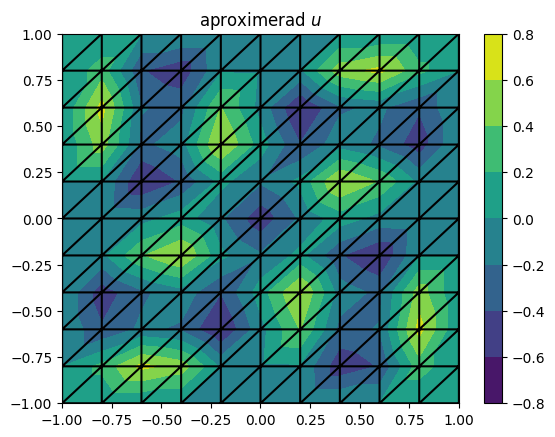

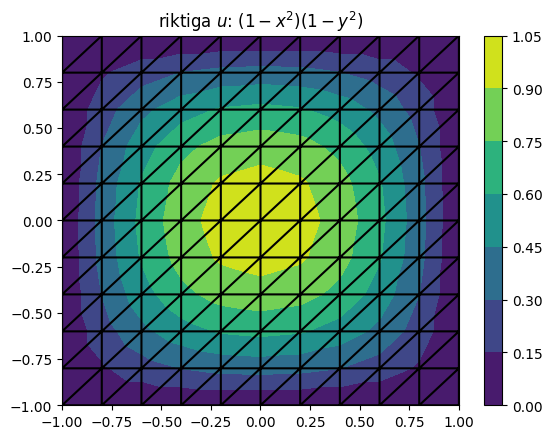

In [1126]:
# Här är det som beror på just vårt problem

def test_solve():
    #==== SETUP: definiera alla argument för vårt problem ====

    def a_integrand(i: AkIntegrandArgs) -> float:
        def beta(pos: Vector2) -> Vector2:
            (x,), (y,) = pos
            return np.asarray([[-y], [x]])
        epsilon = 1.0
        ak = dot2(epsilon * i.nabla_u, i.nabla_v) + dot2(beta(i.x), i.nabla_u) * i.v
        #print(f"ε∇{npfmt(i.nabla_u)} . {npfmt(i.nabla_v)}"
        #      f"+ {npfmt(beta(i.x))} . ∇{npfmt(beta(i.nabla_v))}{float(i.v)}"
        #      f" -> {ret}")
        return ak * i.dx

    def b_integrand(i: AkIntegrandArgs) -> float:
        def f(pos: Vector2) -> float:
            (x,), (y,) = pos
            return 2*(2-x**2-y**2) + 2*x*y*(x**2-y**2)
        #print(f"f({npfmt(i.x)}) = {f(i.x)}")
        bk = f(i.x) * i.v
        return bk * i.dx

    def dirilecht(i: DirilechtArgs):
        # Applicera Dirilectvilkor (≈6.262)
        for pidx, ((x,), (y,)) in enumerate(i.trigrid.V):
            # nollställ alla A/B som ligger på randen av Omega
            if np.isclose(x, -1) or np.isclose(x, 1) or np.isclose(y, -1) or np.isclose(y, 1):
                i.mut_A[pidx, :] = 0
                i.mut_A[:, pidx] = 0
                i.mut_B[pidx] = 0

            # diagonalen ska vara 1
            i.mut_A[pidx, pidx] = 1

    #==== SETUP: nätet ====#
    rx = 10
    trigrid = TriangulatedGrid(nx=rx, ny=rx, xmin=-1, xmax=1, ymin=-1, ymax=1)

    #==== Lös problemet ====#
    solve = StiffnessMatrixSolve2d(
        trigrid=trigrid,
        lhs=a_integrand,
        rhs=b_integrand,
        dirilecht=dirilecht,
    )

    #==== Plotta Reusultatet ====#
    plt.spy(solve.A)
    plt.show()

    #test_k_coords(trigrid)

    U: ndarray = scipy.sparse.linalg.spsolve(solve.A, solve.B)
    print(f"{solve.A.shape=} {solve.B.shape=} {U.shape=} {trigrid.V.shape=}")
    #print(f"A={solve.A}")
    #print(f"B={solve.B}")

    show_trigrid_evaluated(trigrid, solve.B[:,0], title="lastvektor $b$")
    show_trigrid_evaluated(trigrid, U, title="aproximerad $u$")

    U_real = (1-np.pow(trigrid.xs, 2)) * (1-np.pow(trigrid.ys, 2))
    show_trigrid_evaluated(trigrid, U_real, "riktiga $u$: $(1-x^2)(1-y^2)$")

test_solve()


> RE:
>
> $u = (1-x^2)(1-y^2) = 1-x^2-y^2+x^2y^2$